### Imports

In [1]:
import json
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn import preprocessing as preproc
from sklearn.decomposition import PCA
import numpy as np

from scipy import stats

# https://stackoverflow.com/questions/52285104/3d-scatterplots-with-hue-colormap-and-legend
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

try:
  from google.colab import drive
  drive.mount('/content/drive')

  COLAB = True
except ModuleNotFoundError:
  COLAB = False

def display_df(df: pd.DataFrame, title: str = ""):
  display(df.style.hide(axis="index").set_caption(title))

%matplotlib inline

# Download Data
To download the data you can go to [this link](https://drive.google.com/file/d/1NjvuEXyX65fQT7K4TFmxo1VGoJVNQwU4/view?usp=drive_link).

If using colab: upload the data to your own google-drive inside a folder called `predictive-analysis`.

# Data Gathering

In [2]:
if COLAB:
  df_raw = pd.read_csv('/content/drive/MyDrive/predictive-analysis/diabetic_data.csv')
else:
  df_raw = pd.read_csv("diabetic_data.csv")

df_raw.head().T

,0,1,2,3,4
encounter_id,2278392,149190,64410,500364,16680
patient_nbr,8222157,55629189,86047875,82442376,42519267
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50)
weight,?,?,?,?,?
admission_type_id,6,1,1,1,1
discharge_disposition_id,25,1,1,1,1
admission_source_id,1,7,7,7,7
time_in_hospital,1,3,2,2,1


In [3]:
CAT_COLUMNS = [
  "encounter_id", "patient_nbr",
  "race", "gender", "age", "weight", "payer_code", "medical_specialty",
  "diag_1", "diag_2", "diag_3", "max_glu_serum", "A1Cresult", "metformin",
  "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide",
  "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone",
  "acarbose", "miglitol", "troglitazone", "tolazamide",
  "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin",
  "glimepiride-pioglitazone", "metformin-rosiglitazone",
  "metformin-pioglitazone", "change", "diabetesMed", 
  "admission_type_id", "discharge_disposition_id", "admission_source_id",
]
print(f"num of categorical columns: {len(CAT_COLUMNS)}")

num of categorical columns: 41


In [4]:
NUM_COLUMNS = [
  "time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications",
  "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses"
]
print(f"num of numerical columns: {len(NUM_COLUMNS)}")

num of numerical columns: 8


In [5]:
TGT = "readmitted"

In [6]:
# copping the dataset df_raw to df
df = df_raw.copy()

In [7]:
df.shape

(101766, 50)

In [8]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

## Data Preparation

Replace all the "?" and "Unknown/Invalid" in the dataset for `None` values and counting the nulls

In [9]:
df = df.replace("?", None)
df = df.replace("Unknown/Invalid", None)
df.isnull().sum().sort_values(ascending=False)

weight                      98569
max_glu_serum               96420
A1Cresult                   84748
medical_specialty           49949
payer_code                  40256
race                         2273
diag_3                       1423
diag_2                        358
diag_1                         21
gender                          3
time_in_hospital                0
admission_source_id             0
num_lab_procedures              0
encounter_id                    0
patient_nbr                     0
discharge_disposition_id        0
admission_type_id               0
age                             0
number_inpatient                0
number_emergency                0
number_outpatient               0
num_medications                 0
num_procedures                  0
number_diagnoses                0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

Set categorical cols as categories

In [10]:
# set all categorical columns to type 'category'
for col in CAT_COLUMNS + [TGT]:
  df[col] = df[col].astype('category')

df[CAT_COLUMNS + [TGT]].dtypes

encounter_id                category
patient_nbr                 category
race                        category
gender                      category
age                         category
weight                      category
payer_code                  category
medical_specialty           category
diag_1                      category
diag_2                      category
diag_3                      category
max_glu_serum               category
A1Cresult                   category
metformin                   category
repaglinide                 category
nateglinide                 category
chlorpropamide              category
glimepiride                 category
acetohexamide               category
glipizide                   category
glyburide                   category
tolbutamide                 category
pioglitazone                category
rosiglitazone               category
acarbose                    category
miglitol                    category
troglitazone                category
t

## describe attributes

Tgt variable distribution

In [11]:
df[TGT].value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

categorical variables distribution

In [12]:
df[CAT_COLUMNS].describe().T.sort_values(by="unique")

,count,unique,top,freq
citoglipton,101766,1,No,101766
examide,101766,1,No,101766
metformin-rosiglitazone,101766,2,No,101764
tolbutamide,101766,2,No,101743
glimepiride-pioglitazone,101766,2,No,101765
acetohexamide,101766,2,No,101765
metformin-pioglitazone,101766,2,No,101765
glipizide-metformin,101766,2,No,101753
diabetesMed,101766,2,Yes,78363
troglitazone,101766,2,No,101763


numerical variables distribution

In [13]:
percentiles = [.25, .5, .75, .8, .85, .9, .95, .99]
df[NUM_COLUMNS].describe(percentiles).T

,count,mean,std,min,25%,50%,75%,80%,85%,90%,95%,99%,max
time_in_hospital,101766.0,4.395987,2.985108,1.0,2.0,4.0,6.0,7.0,8.0,9.0,11.0,14.0,14.0
num_lab_procedures,101766.0,43.095641,19.674362,1.0,31.0,44.0,57.0,60.0,63.0,67.0,73.0,85.0,132.0
num_procedures,101766.0,1.339730,1.705807,0.0,0.0,1.0,2.0,3.0,3.0,4.0,5.0,6.0,6.0
num_medications,101766.0,16.021844,8.127566,1.0,10.0,15.0,20.0,22.0,24.0,26.0,31.0,43.0,81.0
number_outpatient,101766.0,0.369357,1.267265,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,5.0,42.0
number_emergency,101766.0,0.197836,0.930472,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,76.0
number_inpatient,101766.0,0.635566,1.262863,0.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0,6.0,21.0
number_diagnoses,101766.0,7.422607,1.933600,1.0,6.0,8.0,9.0,9.0,9.0,9.0,9.0,9.0,16.0


# Data Cleaning

### Duplicates rows

In [14]:
df.duplicated().sum()

0

The dataset has no duplicate rows

## Irrelevant features

The columns `weight`, `max_glu_serum` and `A1result` can be removed due to a considerable **proportion of nulls**.

In [15]:
df = df.drop(columns=["weight", "max_glu_serum", "A1Cresult"])
CAT_COLUMNS.remove("weight")
CAT_COLUMNS.remove("max_glu_serum")
CAT_COLUMNS.remove("A1Cresult")

`encounter_id` has one value for each row, consistent with the definition "Unique identifier of an encounter". We can remove it.

In [16]:
df = df.drop(columns=["encounter_id"], errors="ignore")
CAT_COLUMNS.remove("encounter_id")

`citoglipton` and `examide` have only one value for all the rows, so we can remove them from the dataset

In [17]:
df = df.drop(columns=["citoglipton", "examide"], errors="ignore")
CAT_COLUMNS.remove("citoglipton")
CAT_COLUMNS.remove("examide")

`patient_nbr` is the "Unique identifier of a patient" (by the dataset definition). We can remove it.

In [18]:
df = df.drop(columns=["patient_nbr"], errors="ignore")
CAT_COLUMNS.remove("patient_nbr")

dropping a bunch of columns due to SUPER skewed distribution. They can be removed without losing much information, basically each of the points that has the levels in these columns will be considered outliers

In [19]:
DROP_CAT_COLUMNS = [
    "nateglinide", # prop: 11:24:668:101063
    "chlorpropamide", # prop: 1:6:79:101680
    "acetohexamide", # prop: 1:101765
    "tolbutamide", # prop: 23:101742
    "acarbose", # prop: 3:10:295:101458
    "miglitol", # prop 2:5:31:101728
    "troglitazone", # prop: 3:101763
    "tolazamide", # prop 1:38:101727
    "glipizide-metformin", # prop: 13:101753
    "glimepiride-pioglitazone", # prop: 1:101765
    "metformin-rosiglitazone", # prop: 2:101764
    "metformin-pioglitazone", # prop: 1:101765 
]

for c in DROP_CAT_COLUMNS:
    display(df[c].value_counts())
    df = df.drop(columns=[c], errors="ignore")
    CAT_COLUMNS.remove(c)

nateglinide
No        101063
Steady       668
Up            24
Down          11
Name: count, dtype: int64

chlorpropamide
No        101680
Steady        79
Up             6
Down           1
Name: count, dtype: int64

acetohexamide
No        101765
Steady         1
Name: count, dtype: int64

tolbutamide
No        101743
Steady        23
Name: count, dtype: int64

acarbose
No        101458
Steady       295
Up            10
Down           3
Name: count, dtype: int64

miglitol
No        101728
Steady        31
Down           5
Up             2
Name: count, dtype: int64

troglitazone
No        101763
Steady         3
Name: count, dtype: int64

tolazamide
No        101727
Steady        38
Up             1
Name: count, dtype: int64

glipizide-metformin
No        101753
Steady        13
Name: count, dtype: int64

glimepiride-pioglitazone
No        101765
Steady         1
Name: count, dtype: int64

metformin-rosiglitazone
No        101764
Steady         2
Name: count, dtype: int64

metformin-pioglitazone
No        101765
Steady         1
Name: count, dtype: int64

## Remaining missing values

After handling with irrelevant features 7 columns remained with null values (gender, race, payer_code, medical_specialty, diag_1, diag_2, diag_3).

- payer code and medical specialty we will keep it! as they are, if the ML model that you choose cannot handle with null values, **REMOVE THESE COLUMNS**.
- diag_1, diag_2, diag_3 we will remove the rows
- race and gender we will do random sample imputation


`Medical_specialty` and `payer_code` were not removed, but it could be. They have a high number of null variables but they also carry a considerable amount of variance that can be useful for the models

In [20]:
df[["medical_specialty"]].value_counts()

medical_specialty            
InternalMedicine                 14635
Emergency/Trauma                  7565
Family/GeneralPractice            7440
Cardiology                        5352
Surgery-General                   3099
                                 ...  
Psychiatry-Addictive                 1
Neurophysiology                      1
Pediatrics-InfectiousDiseases        1
SportsMedicine                       1
Speech                               1
Name: count, Length: 72, dtype: int64

In [21]:
df[["payer_code"]].value_counts()

payer_code
MC            32439
HM             6274
SP             5007
BC             4655
MD             3532
CP             2533
UN             2448
CM             1937
OG             1033
PO              592
DM              549
CH              146
WC              135
OT               95
MP               79
SI               55
FR                1
Name: count, dtype: int64

regarding the null values in the columns `diag_3`, `diag_2`, `diag_1` we will drop those rows.
These count for 1522 out of 101766, around 1.5%. These columns show a high level of complexity (many levels), thus the impact of removing those records rather then doing any type of imputation will be minimal.

In [22]:
df[df.diag_3.isnull() | df.diag_2.isnull() | df.diag_1.isnull()].shape

(1522, 31)

In [23]:
df = df.dropna(subset=["diag_3", "diag_2", "diag_1"])

regarding the null values in race, we will run random sample imputation (sampling from the race and gender distribution - the mode has the highest chance to be chosen).

In [24]:
# race
valid_races = df.race.dropna().values
missing_values_indices = df.race.isna()
race_sample = np.random.choice(valid_races, missing_values_indices.sum())

df.loc[missing_values_indices, "race"] = race_sample

In [25]:
# gender
valid_genders = df.gender.dropna().values
missing_values_indices = df.gender.isna()
gender_sample = np.random.choice(valid_genders, missing_values_indices.sum())

df.loc[missing_values_indices, "gender"] = gender_sample

null values in the dataset

In [26]:
df.isna().sum()

race                            0
gender                          0
age                             0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  39455
medical_specialty           49482
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
metformin                       0
repaglinide                     0
glimepiride                     0
glipizide                       0
glyburide                       0
pioglitazone                    0
rosiglitazone                   0
insulin                         0
glyburide-metformin             0
change                          0
diabetesMed   

## Data type transformation

There is no much to be done here, though there is one thing that I think it is helpful just to show them that we are using all the things they teach.

In [27]:
MEDICINE_COLUMNS = [
    "metformin", "repaglinide", 
    # "nateglinide", "chlorpropamide", 
    "glimepiride", 
    #"acetohexamide", 
    "glipizide", "glyburide", 
    #"tolbutamide", 
    "pioglitazone", "rosiglitazone", 
    #"acarbose", "miglitol", "troglitazone", "tolazamide",
    "insulin", "glyburide-metformin",
    #"glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"
]

for c in MEDICINE_COLUMNS:
    print(f"{c:25s} : {df[c].cat.categories}")

metformin                 : Index(['Down', 'No', 'Steady', 'Up'], dtype='object')
repaglinide               : Index(['Down', 'No', 'Steady', 'Up'], dtype='object')
glimepiride               : Index(['Down', 'No', 'Steady', 'Up'], dtype='object')
glipizide                 : Index(['Down', 'No', 'Steady', 'Up'], dtype='object')
glyburide                 : Index(['Down', 'No', 'Steady', 'Up'], dtype='object')
pioglitazone              : Index(['Down', 'No', 'Steady', 'Up'], dtype='object')
rosiglitazone             : Index(['Down', 'No', 'Steady', 'Up'], dtype='object')
insulin                   : Index(['Down', 'No', 'Steady', 'Up'], dtype='object')
glyburide-metformin       : Index(['Down', 'No', 'Steady', 'Up'], dtype='object')


all this "medicine columns" they have categories that have a type of order, this might be a good opportunity to do a *data type transformation from nominal to ordinal*, and this is what I will do.

We can say that "No" is lower than "Down", "Down" is lower than "Steady", and "Steady" is lower than "Up", so this will be the order.

In [28]:
# cast glimepiride from category to int type following this order ['No', 'Down', 'Steady', 'Up']
from pandas.api.types import CategoricalDtype

medicine_levels = CategoricalDtype(categories=['No', 'Down', 'Steady', 'Up'], ordered=True)

for c in MEDICINE_COLUMNS:
    df[c] = df[c].astype(medicine_levels)

This is great because we reduce a lot the numbers of categorical variables!

One more thing can be done. The column `Change` and `DiabetesMed` can be converted to 0 and 1

In [29]:
df.change = df.change == "Ch"
df.diabetesMed = df.diabetesMed == "Yes"

## Outliers

### Not skewed numerical columns

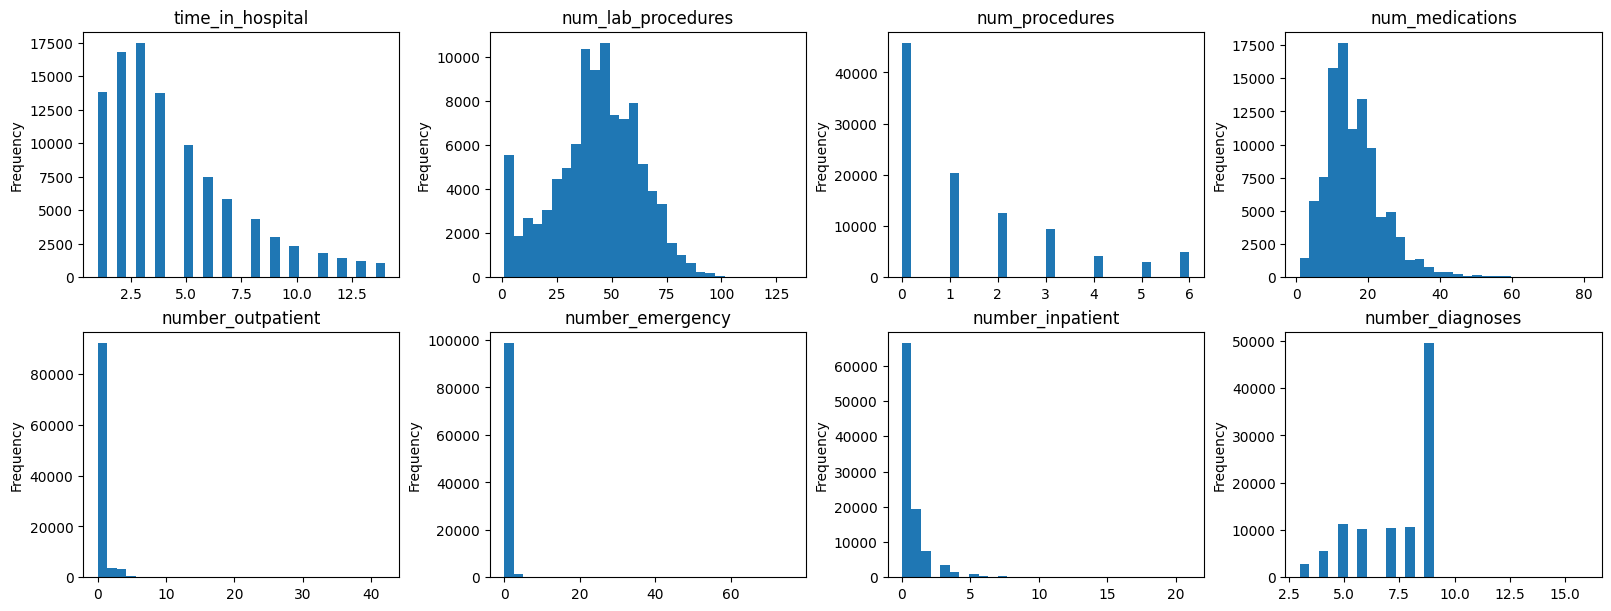

In [30]:
# print df hist exactly as the one above but with 4 columns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), constrained_layout=True)
for i, col in enumerate(NUM_COLUMNS):
    df[col].plot(kind='hist', bins=30, ax=axes[i//4, i%4], title=col)

IQR will work well for some of this columns, but not for all

`time_in_hospital`, `num_lab_procedures`, `num_procedures`, `num_medications`, `number_diagnoses` are the ones we will use IQR

In [31]:

NOT_SKEWED_COLUMNS = ["time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_diagnoses"]

Q1 = df[NOT_SKEWED_COLUMNS].quantile(.25)
Q3 = df[NOT_SKEWED_COLUMNS].quantile(.75)
IQR = Q3 - Q1

outliers_iqr = (df[NOT_SKEWED_COLUMNS] < (Q1 - 1.5 * IQR)) | (df[NOT_SKEWED_COLUMNS] > (Q3 + 1.5 * IQR))

print("not skewed columns - IQR method")

outs = outliers_iqr.sum().reset_index().rename(columns={"index": "attribute", 0: "outliers"})
display_df(outs)

outs = outliers_iqr.sum(axis=1).value_counts().reset_index().rename(columns={"index": "attibute with outlier", "count": "number of rows"})
display_df(outs)

not skewed columns - IQR method


attribute,outliers
time_in_hospital,2246
num_lab_procedures,217
num_procedures,4940
num_medications,3396
number_diagnoses,62


attibute with outlier,number of rows
0,91134
1,7563
2,1349
3,192
4,6


using IQR method we have almost 10% of the rows with at least one outlier, this is a very high number.

Therefore, I decided to check how will be with we use the Z-score method to detect outliers (using 3 std dev):

In [32]:
print("not skewed columns - Z-score method")

z = np.abs(stats.zscore(df[NOT_SKEWED_COLUMNS]))
out_zscore = z > 3

outliers_zscore = pd.DataFrame(out_zscore, columns=NOT_SKEWED_COLUMNS)
outs = outliers_zscore.sum().reset_index().rename(columns={"index": "attribute", 0: "outliers"})
display_df(outs)

print("Number of instances by number of outliers:")
outs = outliers_zscore.sum(axis=1).value_counts().reset_index().rename(columns={"index": "attibute with outlier", "count": "number of rows"})
display_df(outs)


not skewed columns - Z-score method


attribute,outliers
time_in_hospital,1041
num_lab_procedures,43
num_procedures,0
num_medications,1360
number_diagnoses,62


Number of instances by number of outliers:


attibute with outlier,number of rows
0,97843
1,2296
2,105


here we have a more reasonable number of outliers, around 3% of the dataset.

Let's see if we get 99% percentile

In [33]:
print("not skewed columns - 99 percentile method")

outliers_perc = df[NOT_SKEWED_COLUMNS] > df[NOT_SKEWED_COLUMNS].quantile(.99)
outs = outliers_perc.sum().reset_index().rename(columns={"index": "attribute", 0: "outliers"})
display(outs.style.hide(axis="index"))

outs = outliers_perc.sum(axis=1).value_counts().reset_index().rename(columns={"index": "attibute with outlier", "count": "number of rows"})
display(outs.style.hide(axis="index"))

not skewed columns - 99 percentile method


attribute,outliers
time_in_hospital,0
num_lab_procedures,886
num_procedures,0
num_medications,959
number_diagnoses,115


attibute with outlier,number of rows
0,98352
1,1824
2,68


If we decide by removing the 99% percentile outliers, we would remove 1% of the dataset. 

let's see how much of the outliers detected via the methods are contained in the others

In [34]:
idx_zscore = outliers_zscore.sum(axis=1) > 0
idx_zscore = set(df.loc[idx_zscore].index)

idx_iqr = outliers_iqr.sum(axis=1) > 0
idx_iqr = set(df.loc[idx_iqr].index)

idx_perc = outliers_perc.sum(axis=1) > 0
idx_perc = set(df.loc[idx_perc].index)

# intersection of idx_iqr and idx_zscore
cap_iqr_zscore = len(idx_iqr & idx_zscore)
cap_iqr_perc = len(idx_iqr & idx_perc)
cap_zscore_perc = len(idx_zscore & idx_perc)

outs = pd.DataFrame(
        {
            "method": ["IQR", "ZSCORE", "99 percentile"],
            "Intersection with IQR": [len(idx_iqr), cap_iqr_zscore, cap_iqr_perc],
            "Intersection with ZScore": [cap_iqr_zscore, len(idx_zscore), cap_zscore_perc],
            "Intersection with 99 percentile": [cap_iqr_perc, cap_zscore_perc, len(idx_perc)],
        }
)

display_df(outs)

method,Intersection with IQR,Intersection with ZScore,Intersection with 99 percentile
IQR,9110,2401,1388
ZSCORE,2401,2401,1115
99 percentile,1388,1115,1892


All the outliers that `Z-score > 3 found`, IQR also found, which means that in this case, Z-score is a subset of IQR, thus, Z-score is a more conservative approach.

Though the outliers found by the 99 percentile method don't overlap with the other two methods. They have common elements but percentile 99 method has other points not identified by the other two methods. Somehow this shows that this is not a good approach, though I will analyse it anyway.

To analyse if we can remove them we must be sure that those outliers occur way randomly. We can run a chi square test to be sure.

In [35]:
print("TGT proportion in the dataset - Not Skewed columns - outlier detection")

prop = df_raw.loc[:, TGT].value_counts().reset_index()
display_df(prop.sort_values("readmitted", ascending = False), "full dataset")

prop = df.loc[list(idx_iqr), TGT].value_counts().reset_index()
display_df(prop.sort_values("readmitted", ascending = False), "IQR outliers")

prop = df.loc[list(idx_zscore), TGT].value_counts().reset_index()
display_df(prop.sort_values("readmitted", ascending = False), "Z-score outliers")

prop = df.loc[list(idx_perc), TGT].value_counts().reset_index()
display_df(prop.sort_values("readmitted", ascending = False), "99 percentile outliers")

TGT proportion in the dataset - Not Skewed columns - outlier detection


readmitted,count
NO,54864
>30,35545
<30,11357


readmitted,count
NO,5159
>30,2936
<30,1015


readmitted,count
NO,1409
>30,711
<30,281


readmitted,count
NO,1159
>30,523
<30,210


In [36]:
# chi2 fulldataset vs IQR
stats.chi2_contingency(np.array([[54864, 35545 + 11357], [5159, 2936 + 1015]]))

Chi2ContingencyResult(statistic=24.772044055028907, pvalue=6.452658203230575e-07, dof=1, expected_freq=array([[55091.27870775, 46674.72129225],
       [ 4931.72129225,  4178.27870775]]))

In [37]:
# chi2 fulldataset vs Z-score
stats.chi2_contingency(np.array([[54864, 35545 + 11357], [1409, 711+281]]))

Chi2ContingencyResult(statistic=21.313262979526932, pvalue=3.900236869793347e-06, dof=1, expected_freq=array([[54975.93400981, 46790.06599019],
       [ 1297.06599019,  1103.93400981]]))

In [38]:
# chi2 fulldataset vs Z-score
stats.chi2_contingency(np.array([[54864, 35545 + 11357], [1159, 523+210]]))

Chi2ContingencyResult(statistic=40.06349196304314, pvalue=2.4584086715805505e-10, dof=1, expected_freq=array([[55000.44972892, 46765.55027108],
       [ 1022.55027108,   869.44972892]]))

All methods showed a super low p-value (10^-7, 10^-6 and 10^-10); this means that the distribution of the target variable is not independent of the outliers identified compared to the entire dataset. Removing or changing those outliers will generate bias, thus, we will keep them as they are.

### Skewed numerical columns

The 3 remaining numerical columns are heavily skewed, in a way that the IQR method is not applicable (IQR distance is 0). Thus, I will compare three different methods, Zscore and percentile 99 and percentile 99.5.

In [39]:
ALT_APPROACH_COLUMNS = ["number_outpatient", "number_emergency", "number_inpatient"]

print("skewed columns - Z-score method")

z = np.abs(stats.zscore(df[ALT_APPROACH_COLUMNS]))
alt_zscore = z > 3

outliers_alt_zscore = pd.DataFrame(alt_zscore, columns=ALT_APPROACH_COLUMNS)
outs = outliers_alt_zscore.sum().reset_index().rename(columns={"index": "attribute", 0: "outliers"})
display(outs.style.hide(axis="index"))

outs = outliers_alt_zscore.sum(axis=1).value_counts().reset_index().rename(columns={"index": "attibute with outlier", "count": "number of rows"})
display(outs.style.hide(axis="index"))


skewed columns - Z-score method


attribute,outliers
number_outpatient,1449
number_emergency,1648
number_inpatient,1994


attibute with outlier,number of rows
0,95649
1,4108
2,478
3,9


In [40]:
print("skewed columns - 99 percentile method")

outliers_alt_99_perc = df[ALT_APPROACH_COLUMNS] > df[ALT_APPROACH_COLUMNS].quantile(.99)
outs = outliers_alt_99_perc.sum().reset_index().rename(columns={"index": "attribute", 0: "outliers"})
display(outs.style.hide(axis="index"))

outs = outliers_alt_99_perc.sum(axis=1).value_counts().reset_index().rename(columns={"index": "attibute with outlier", "count": "number of rows"})
display(outs.style.hide(axis="index"))

skewed columns - 99 percentile method


attribute,outliers
number_outpatient,920
number_emergency,930
number_inpatient,713


attibute with outlier,number of rows
0,97863
1,2204
2,172
3,5


In [41]:
idx_alt_zscore = outliers_alt_zscore.sum(axis=1) > 0
idx_alt_zscore = set(df.loc[idx_alt_zscore].index)

idx_alt_99_perc = outliers_alt_99_perc.sum(axis=1) > 0
idx_alt_99_perc = set(df.loc[idx_alt_99_perc].index)

# intersection of idx_alt_zscore and idx_alt_perc
cap_alt_zscore_99_perc = len(idx_alt_zscore & idx_alt_99_perc)

outs = pd.DataFrame(
        {
            "method": ["ZSCORE", "99 Percentile"],
            "Intersection with zscore": [len(idx_alt_zscore),  cap_alt_zscore_99_perc],
            "Intersection with 99 percentile": [cap_alt_zscore_99_perc, len(idx_alt_99_perc)],
        }
)

outs.style.hide(axis="index")


method,Intersection with zscore,Intersection with 99 percentile
ZSCORE,4595,2381
99 Percentile,2381,2381


For these columns, the outliers in the 99 percentile are also in the z-score method for the skewed columns; this is happening due to the high skewness of the data. 

Let's analyse if removing them will add bias to the target.

In [42]:
print("TGT proportion in the dataset - Skewed columns - outlier detection")

prop = df_raw.loc[:, TGT].value_counts().reset_index()
display_df(prop.sort_values("readmitted", ascending = False), "full dataset")

prop = df.loc[list(idx_alt_zscore), TGT].value_counts().reset_index()
display_df(prop.sort_values("readmitted", ascending = False), "Z-score outliers")

prop = df.loc[list(idx_alt_99_perc), TGT].value_counts().reset_index()
display_df(prop.sort_values("readmitted", ascending = False), "99 percentile outliers")

TGT proportion in the dataset - Skewed columns - outlier detection


readmitted,count
NO,54864
>30,35545
<30,11357


readmitted,count
NO,1179
>30,2297
<30,1119


readmitted,count
NO,556
>30,1222
<30,603


In [43]:
# chi2 fulldataset vs Z-score
stats.chi2_contingency(np.array([[54864, 35545 + 11357], [1179, 2297+1119]]))

Chi2ContingencyResult(statistic=1406.7713219286816, pvalue=7.095923604195486e-308, dof=1, expected_freq=array([[53621.83448821, 48144.16551179],
       [ 2421.16551179,  2173.83448821]]))

In [44]:
# chi2 fulldataset vs 99 percentile
stats.chi2_contingency(np.array([[54864, 35545 + 11357], [556, 1222+603]]))

Chi2ContingencyResult(statistic=871.5237222163626, pvalue=1.5217098683096276e-191, dof=1, expected_freq=array([[54152.992597, 47613.007403],
       [ 1267.007403,  1113.992597]]))

None of these methods can be used because they will significantly increase the bias in the target if we remove those outliers.

**Therefore, no outlier will be removed from the dataset due to statistical methods, maybe later we can remove using more robust methods.**

# Last View before Saving

In [45]:
display(df.shape)
df.dtypes

(100244, 31)

race                        category
gender                      category
age                         category
admission_type_id           category
discharge_disposition_id    category
admission_source_id         category
time_in_hospital               int64
payer_code                  category
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
metformin                   category
repaglinide                 category
glimepiride                 category
glipizide                   category
glyburide                   category
pioglitazone                category
rosiglitazone               category
insulin                     category
g

In [46]:
df.head().T

,1,2,3,4,5
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,Female,Female,Male,Male,Male
age,[10-20),[20-30),[30-40),[40-50),[50-60)
admission_type_id,1,1,1,1,2
discharge_disposition_id,1,1,1,1,1
admission_source_id,7,7,7,7,2
time_in_hospital,3,2,2,1,3
payer_code,NaN,NaN,NaN,NaN,NaN
medical_specialty,NaN,NaN,NaN,NaN,NaN
num_lab_procedures,59,11,44,51,31


# Save Data cleaned

In [47]:
# setting genter Unknown/Invalid as None
df = df.reset_index(drop=True)

display(df.shape)
display(df.dtypes)

if COLAB:
  df.to_csv('/content/drive/MyDrive/predictive-analysis/diabetic_data_cleaned.csv', index=False)
  df.to_parquet('/content/drive/MyDrive/predictive-analysis/diabetic_data_cleaned.parquet')
else:
  df.to_csv("diabetic_data_cleaned.csv", index=False)
  df.to_parquet("diabetic_data_cleaned.parquet")

data_dict = {
  "Numeric Columns": NUM_COLUMNS,
  "Categorical Columns": CAT_COLUMNS,
  "Target": TGT
}

if COLAB:
  with open('/content/drive/MyDrive/predictive-analysis/data_dictionary.json', 'w') as f:
    json.dump(data_dict, f)
else:
  with open("data_dictionary.json", "w") as f:
    json.dump(data_dict, f, indent=4)

(100244, 31)

race                        category
gender                      category
age                         category
admission_type_id           category
discharge_disposition_id    category
admission_source_id         category
time_in_hospital               int64
payer_code                  category
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
metformin                   category
repaglinide                 category
glimepiride                 category
glipizide                   category
glyburide                   category
pioglitazone                category
rosiglitazone               category
insulin                     category
g